In [3]:
import os
import json
from tqdm import tqdm
import warnings

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dpipe.io import load
from dpipe.dataset.wrappers import apply, cache_methods
from dpipe.im.metrics import dice_score, iou
from ood.dataset.cc359 import CC359
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import CC359_DATA_PATH
from ood.torch.module.unet_mc_dropout import UNet3D_MC_Dropout
from ood.utils import sdice
from ood.metric.ood_metric import calc_ood_scores
from ood.batch_iter.augmentations import rotate90, flip


data_path = CC359_DATA_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
voxel_spacing = (1, 0.95, 0.95)
sdice_metric = lambda x, y, i: sdice(x, y, dataset.load_spacing(i), 1)

preprocessed_dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)
dataset = apply(cache_methods(apply(preprocessed_dataset, load_image=np.float16), maxsize=30), 
                load_image=np.float32)

in_distr_id = 1
n_folds = 6
ood_ids = [i for i in range(n_folds) if i != in_distr_id]
n_seeds = 5
bin_threshold = 0.5
eps = 1e-8

experiment_dir = '/mount/sdc/experiments/ood_playground/cc359/'

In [4]:
ood_metrics = np.zeros((n_folds, 1))

for seed in [0]:
    base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/')
    with open(os.path.join(base_dir, 'test_metrics', 'dice_score.json')) as file:
        metrics = json.load(file)

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id, seed] = in_distr_metric
    print('In distribution:', in_distr_metric)

    for fold_id in ood_ids:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id, seed] = ood_metric
        print(f'OOD fold {fold_id}:', ood_metric)
        
means = ood_metrics.mean(axis=1)
stds = ood_metrics.std(axis=1)

for i in range(n_folds):
    print(f'Fold {i}:\tood = {i != in_distr_id}\t', means[i], '±', 2 * stds[i])
    
print()
ood_ids = [i for i in range(n_folds) if i != in_distr_id]
print('In distr:\t', means[in_distr_id], '±', 2 * stds[in_distr_id])
print('OOD:\t\t', ood_metrics[ood_ids].mean(), '±', 2 * ood_metrics[ood_ids].std())

true_dice = means[in_distr_id]

In distribution: 0.9815540329213228
OOD fold 0: 0.9517428535411991
OOD fold 2: 0.6994646067404594
OOD fold 3: 0.9605608577911162
OOD fold 4: 0.9150867130799113
OOD fold 5: 0.8859726581648507
Fold 0:	ood = True	 0.9517428535411991 ± 0.0
Fold 1:	ood = False	 0.9815540329213228 ± 0.0
Fold 2:	ood = True	 0.6994646067404594 ± 0.0
Fold 3:	ood = True	 0.9605608577911162 ± 0.0
Fold 4:	ood = True	 0.9150867130799113 ± 0.0
Fold 5:	ood = True	 0.8859726581648507 ± 0.0

In distr:	 0.9815540329213228 ± 0.0
OOD:		 0.8825655378635073 ± 0.190712259111599


In [5]:
ood_metrics = np.zeros((n_folds, 1))

for seed in [0]:
    base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/')
    with open(os.path.join(base_dir, 'test_metrics', 'sdice_score.json')) as file:
        metrics = json.load(file)

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id, seed] = in_distr_metric
    print('In distribution:', in_distr_metric)

    for fold_id in ood_ids:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id, seed] = ood_metric
        print(f'OOD fold {fold_id}:', ood_metric)
        
means = ood_metrics.mean(axis=1)
stds = ood_metrics.std(axis=1)

for i in range(n_folds):
    print(f'Fold {i}:\tood = {i != in_distr_id}\t', means[i], '±', 2 * stds[i])

print()
ood_ids = [i for i in range(n_folds) if i != in_distr_id]
print('In distr:\t', means[in_distr_id], '±', 2 * stds[in_distr_id])
print('OOD:\t\t', ood_metrics[ood_ids].mean(), '±', 2 * ood_metrics[ood_ids].std())

true_sdice = means[in_distr_id]

In distribution: 0.9116250344277849
OOD fold 0: 0.7130241475943397
OOD fold 2: 0.19534337180512198
OOD fold 3: 0.7531874316792503
OOD fold 4: 0.6051681394580902
OOD fold 5: 0.5313330565170565
Fold 0:	ood = True	 0.7130241475943397 ± 0.0
Fold 1:	ood = False	 0.9116250344277849 ± 0.0
Fold 2:	ood = True	 0.19534337180512198 ± 0.0
Fold 3:	ood = True	 0.7531874316792503 ± 0.0
Fold 4:	ood = True	 0.6051681394580902 ± 0.0
Fold 5:	ood = True	 0.5313330565170565 ± 0.0

In distr:	 0.9116250344277849 ± 0.0
OOD:		 0.5596112294107718 ± 0.39655862492212807


In [6]:
image = dataset.load_image(dataset.ids[0])

axial indeces:


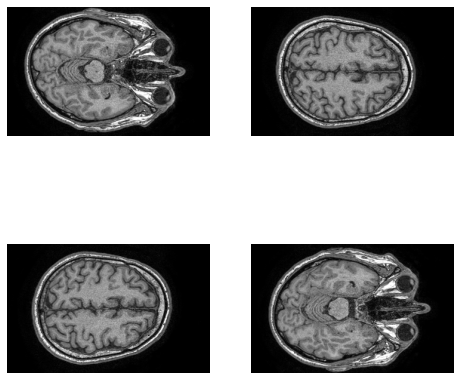

In [18]:
K = 2
ss = [100, -100]
print('axial indeces:')

img = image
segm = np.rot90(image, k=2, axes=(-3, -1))
# targ = target

lim1 = 0
lim2 = img.shape[0]
lim3 = 0
lim4 = img.shape[1]

# lim1 = 50
# lim2 = 200
# lim3 = 50
# lim4 = 200

fig, ax = plt.subplots(nrows=2, ncols=K, figsize=(4 * K, 4 * 2))
row = 0
for i, s in enumerate(ss):
    axial = img[..., s][lim1:lim2, lim3:lim4]
    ax[row, i].imshow(axial, cmap='gray')
    ax[row, i].axis('off')

row = 1
for i, s in enumerate(ss):
    axial = segm[..., s][lim1:lim2, lim3:lim4]
    ax[row, i].imshow(axial, cmap='gray')
    ax[row, i].axis('off')
    
# row = 2
# for i, s in enumerate(ss):
#     axial = targ[..., s][lim1:lim2, lim3:lim4]
#     ax[row, i].imshow(axial, cmap='gray')
#     ax[row, i].axis('off')

In [19]:
true_labels_abs = {}
base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/test_predictions')
filenames = os.listdir(base_dir)
for i in tqdm(range(len(filenames))):
    uid = filenames[i].split('.')[0]
    if dataset.df.fold[uid] != in_distr_id:
        continue
    preds = load(os.path.join(base_dir, filenames[i]))
    uncertainty_result = np.zeros_like(preds)
    uncertainty_result[preds > 0.5] = (1 - preds)[preds > 0.5]
    uncertainty_result[preds <= 0.5] = preds[preds <= 0.5]
    label = uncertainty_result.mean()
    true_labels_abs[filenames[i].split('.')[0]] = label
    
true_labels_entr = {}
base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/test_predictions')
filenames = os.listdir(base_dir)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in tqdm(range(len(filenames))):
        uid = filenames[i].split('.')[0]
        if dataset.df.fold[uid] != in_distr_id:
            continue
        preds = load(os.path.join(base_dir, filenames[i]))
        uncertainty_result = - (preds * np.log2(preds + eps) + (1 - preds) * np.log2(1 - preds + eps))
        uncertainty_result[preds == 0] = 0
        uncertainty_result[preds == 1] = 0
        label = uncertainty_result.mean()
        true_labels_entr[filenames[i].split('.')[0]] = label

100%|██████████| 329/329 [02:03<00:00,  2.66it/s]


In [20]:
def get_score_augmentation(true_labels, augm_labels):
    if type(augm_labels) == dict:
        augm_labels = list(augm_labels.values())
    scores = np.array(list(true_labels.values()) + augm_labels)
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    return calc_ood_scores(scores, y_true)

In [43]:
def load_labels_and_metrics(exp_dir_list):
    rot_labels = []
    rot_entr_labels = []
    rot_dices = []
    rot_sdices = []

    for rot_exp_dir in exp_dir_list:
        cur_labels = load(os.path.join(rot_exp_dir, 'test_metrics/abs_ue_score.json'))
        cur_entr_labels = load(os.path.join(rot_exp_dir, 'test_metrics/entropy.json'))
        cur_dices = load(os.path.join(rot_exp_dir, 'test_metrics/dice_score.json'))
        cur_sdices = load(os.path.join(rot_exp_dir, 'test_metrics/sdice_score.json'))
        rot_labels += list(cur_labels.values())
        rot_entr_labels += list(cur_entr_labels.values())
        rot_dices += list(cur_dices.values())
        rot_sdices += list(cur_sdices.values())

    real_dice = np.mean(rot_dices)
    real_sdice = np.mean(rot_sdices)
    print(f'Dice:\t{real_dice:.4f}\tdrop:\t{true_dice - real_dice:.4f}')
    print(f'SDice:\t{real_sdice:.4f}\tdrop:\t{true_sdice - real_sdice:.4f}')

    print()
    print('Abs uncertainty')
    get_score_augmentation(true_labels_abs, rot_labels)

    print()
    print('Entropy')
    get_score_augmentation(true_labels_entr, rot_entr_labels);
    return true_labels_entr, rot_entr_labels

In [36]:
exp_dir_list = [os.path.join(experiment_dir, f'crops_and_flips/rot{rot}/experiment_0/') for rot in [1, 3]]
load_labels_and_metrics(exp_dir_list)

Dice:	0.9719	drop:	0.0096
SDice:	0.8299	drop:	0.0817

Abs uncertainty
Detection accuracy: 0.8250
AUROC: 0.8861
TNR @ 95% TPR: 0.4833

Entropy
Detection accuracy: 0.8417
AUROC: 0.8783
TNR @ 95% TPR: 0.5500


In [46]:
exp_dir_list = [os.path.join(experiment_dir, f'crops_and_flips/rotate_patient{rot}/experiment_0/') 
                for rot in [2]]
load_labels_and_metrics(exp_dir_list);

Dice:	0.9456	drop:	0.0360
SDice:	0.7165	drop:	0.1951

Abs uncertainty
Detection accuracy: 0.9833
AUROC: 0.9922
TNR @ 95% TPR: 1.0000

Entropy
Detection accuracy: 0.9833
AUROC: 0.9844
TNR @ 95% TPR: 1.0000


In [26]:
exp_dir_list = [os.path.join(experiment_dir, f'crops_and_flips/rot3_ensemble/seed{seed}/experiment_0/') 
                for seed in range(n_seeds)]
load_labels_and_metrics(exp_dir_list)

Dice:	0.9703	drop:	0.0112
SDice:	0.8135	drop:	0.0981

Abs uncertainty
Detection accuracy: 0.8600
AUROC: 0.9090
TNR @ 95% TPR: 0.5533

Entropy
Detection accuracy: 0.8767
AUROC: 0.9140
TNR @ 95% TPR: 0.6333


In [7]:
det_accs = []
roc_aucs = []
tprs = []
det_accs_ent = []
roc_aucs_ent = []
tprs_ent = []
rot_dices = []
rot_sdices = []

for seed in range(n_seeds):
    rot_exp_dir = os.path.join(experiment_dir, f'crops_and_flips/rot3_ensemble/seed{seed}/experiment_0/')

    cur_labels = load(os.path.join(rot_exp_dir, 'test_metrics/abs_ue_score.json'))
    cur_entr_labels = load(os.path.join(rot_exp_dir, 'test_metrics/entropy.json'))
    cur_dices = load(os.path.join(rot_exp_dir, 'test_metrics/dice_score.json'))
    cur_sdices = load(os.path.join(rot_exp_dir, 'test_metrics/sdice_score.json'))
    rot_labels = list(cur_labels.values())
    rot_entr_labels = list(cur_entr_labels.values())
    rot_dices.append(np.mean(list(cur_dices.values())))
    rot_sdices.append(np.mean(list(cur_sdices.values())))
    
    print()
    print('Abs uncertainty')
    det_acc, roc_auc, tpr = get_score_augmentation(true_labels_abs, rot_labels)
    det_accs.append(det_acc)
    roc_aucs.append(roc_auc)
    tprs.append(tpr)

    print()
    print('Entropy')
    det_acc_ent, roc_auc_ent, tpr_ent = get_score_augmentation(true_labels_entr, rot_entr_labels)
    det_accs_ent.append(det_acc_ent)
    roc_aucs_ent.append(roc_auc_ent)
    tprs_ent.append(tpr_ent)
    
real_dice = np.mean(rot_dices)
real_sdice = np.mean(rot_sdices)
print()
print(f'Dice:\t{real_dice:.4f} ± {1.96 * np.std(rot_dices):.4f}\tdrop:\t{true_dice - real_dice:.4f}')
print(f'SDice:\t{real_sdice:.4f} ± {1.96 * np.std(rot_sdices):.4f}\tdrop:\t{true_sdice - real_sdice:.4f}')

print()
print('Abs uncertainty')
print(f'Detection accuracy:\t{np.mean(det_accs):.4f} ± {1.96 * np.std(det_accs):.4f}')
print(f'AUROC:\t{np.mean(roc_aucs):.4f} ± {1.96 * np.std(roc_aucs):.4f}')
print(f'TNR @ 95% TPR:\t{np.mean(tprs):.4f} ± {1.96 * np.std(tprs):.4f}')

print()
print('Entropy')
print(f'Detection accuracy:\t{np.mean(det_accs_ent):.4f} ± {1.96 * np.std(det_accs_ent):.4f}')
print(f'AUROC:\t{np.mean(roc_aucs_ent):.4f} ± {1.96 * np.std(roc_aucs_ent):.4f}')
print(f'TNR @ 95% TPR:\t{np.mean(tprs_ent):.4f} ± {1.96 * np.std(tprs_ent):.4f}')


Abs uncertainty
Detection accuracy: 0.8167
AUROC: 0.8789
TNR @ 95% TPR: 0.4667

Entropy
Detection accuracy: 0.8500
AUROC: 0.8783
TNR @ 95% TPR: 0.5333

Abs uncertainty
Detection accuracy: 0.9333
AUROC: 0.9478
TNR @ 95% TPR: 0.7333

Entropy
Detection accuracy: 0.9333
AUROC: 0.9511
TNR @ 95% TPR: 0.8000

Abs uncertainty
Detection accuracy: 0.8333
AUROC: 0.8850
TNR @ 95% TPR: 0.5000

Entropy
Detection accuracy: 0.8500
AUROC: 0.8956
TNR @ 95% TPR: 0.5667

Abs uncertainty
Detection accuracy: 0.8667
AUROC: 0.9111
TNR @ 95% TPR: 0.4667

Entropy
Detection accuracy: 0.8500
AUROC: 0.9144
TNR @ 95% TPR: 0.6333

Abs uncertainty
Detection accuracy: 0.8833
AUROC: 0.9222
TNR @ 95% TPR: 0.6000

Entropy
Detection accuracy: 0.9000
AUROC: 0.9306
TNR @ 95% TPR: 0.6333

Dice:	0.9703 ± 0.0032	drop:	0.0112
SDice:	0.8135 ± 0.0329	drop:	0.0981

Abs uncertainty
Detection accuracy:	0.8667 ± 0.0800
AUROC:	0.9090 ± 0.0493
TNR @ 95% TPR:	0.5533 ± 0.2007

Entropy
Detection accuracy:	0.8767 ± 0.0673
AUROC:	0.9140 ± 

In [30]:
exp_dir_list = [os.path.join(experiment_dir, f'crops_and_flips/flip{flip}/experiment_0/') for flip in [0, 1]]
load_labels_and_metrics(exp_dir_list)

Dice:	0.9792	drop:	0.0023
SDice:	0.8872	drop:	0.0244

Abs uncertainty
Detection accuracy: 0.6417
AUROC: 0.6575
TNR @ 95% TPR: 0.1333

Entropy
Detection accuracy: 0.6500
AUROC: 0.6550
TNR @ 95% TPR: 0.1667


In [31]:
exp_dir_list = [os.path.join(experiment_dir, f'crops_and_flips/crop_5/experiment_0/')]
load_labels_and_metrics(exp_dir_list)

Dice:	0.8705	drop:	0.1110
SDice:	nan	drop:	nan

Abs uncertainty
Detection accuracy: 0.8800
AUROC: 0.8863
TNR @ 95% TPR: 0.7933

Entropy
Detection accuracy: 0.8867
AUROC: 0.8872
TNR @ 95% TPR: 0.8067


In [43]:
rot_labels = []
rot_entr_labels = []
rot_dices = []
rot_sdices = []

for rot in [1]:
    rot_exp_dir = rot_exp_dir = os.path.join(experiment_dir, f'crops_and_flips/crop_5/experiment_0/')

    cur_labels = load(os.path.join(rot_exp_dir, 'test_metrics/abs_ue_score.json'))
    cur_entr_labels = load(os.path.join(rot_exp_dir, 'test_metrics/entropy.json'))
    cur_dices = load(os.path.join(rot_exp_dir, 'test_metrics/dice_score.json'))
    cur_sdices = load(os.path.join(rot_exp_dir, 'test_metrics/sdice_score.json'))
    rot_labels += list(cur_labels.values())
    rot_entr_labels += list(cur_entr_labels.values())
    rot_dices += list(cur_dices.values())
    rot_sdices += list(cur_sdices.values())
    
real_dice = np.mean(rot_dices)
real_sdice = np.mean(rot_sdices, where=~np.isnan(rot_sdices))
print(f'Dice:\t{real_dice:.4f}\tdrop:\t{true_dice - real_dice:.4f}')
print(f'SDice:\t{real_sdice:.4f}\tdrop:\t{true_sdice - real_sdice:.4f}')

print()
print('Abs uncertainty')
get_score_augmentation(true_labels_abs, rot_labels)

print()
print('Entropy')
get_score_augmentation(true_labels_entr, rot_entr_labels)

Dice:	0.8705	drop:	0.1110
SDice:	0.7414	drop:	0.1702

Abs uncertainty
Detection accuracy: 0.8800
AUROC: 0.8863
TNR @ 95% TPR: 0.8167

Entropy
Detection accuracy: 0.8867
AUROC: 0.8872
TNR @ 95% TPR: 0.8278


In [11]:
cur_centers = load(os.path.join(rot_exp_dir, 'test_metrics/centers.json'))
cur_shapes = load(os.path.join(rot_exp_dir, 'test_metrics/crop_shapes.json'))

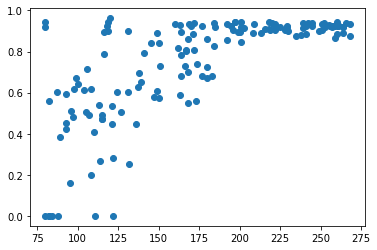

In [14]:
plt.scatter(np.array([val[0] for val in cur_shapes.values()])[~np.isnan(rot_sdices)], 
            np.array(rot_sdices)[~np.isnan(rot_sdices)])

## Ensemble

Entropy

Detection accuracy:	0.8767 ± 0.0673

AUROC:	0.9140 ± 0.0501

TNR @ 95% TPR:	0.7833 ± 0.0901

In [47]:
top_elements = 1000000

labels_std = {}
labels_var = {}
labels_top_std = {}
labels_iou = {}
labels_volume = {}
dices = {}
sdices = {}

base_dir = os.path.join(experiment_dir, f'ensemble/seed0/experiment_0/test_predictions')
filenames = os.listdir(base_dir)
uids = [fname.split('.')[0] for fname in filenames]

for uid in tqdm(uids):
    if dataset.df.fold[uid] != in_distr_id:
        continue
    
    ensemble_preds = []
    ensemble_preds_top = []
    for seed in range(n_seeds):
        base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/test_predictions')
        preds = load(os.path.join(base_dir, uid + '.npy.gz'))
        ensemble_preds.append(preds)
        sorted_preds = np.sort(preds)
        ensemble_preds_top.append(sorted_preds.flatten()[-top_elements:])
    
    ensemble_preds = np.array(ensemble_preds)
    mean_preds = ensemble_preds.mean(axis=0)
    std_preds = ensemble_preds.std(axis=0)
    true_mask = dataset.load_segm(uid)
    dices[uid] = dice_score(mean_preds > bin_threshold, true_mask > bin_threshold)
    sdices[uid] = sdice_metric(mean_preds > bin_threshold, true_mask > bin_threshold, uid)
    labels_std[uid] = std_preds.mean()
    labels_var[uid] = np.square(std_preds).mean()
    
    mean_preds = ensemble_preds.mean(axis=0)
    ious = []
    for i in range(n_seeds):
        ious.append(1 - iou(mean_preds > bin_threshold, ensemble_preds[i] > bin_threshold))
    labels_iou[uid] = np.mean(ious)
    
    volumes = np.array([(pred > bin_threshold).sum() for pred in ensemble_preds])
    mean_volume = volumes.mean()
    std_volume = volumes.std()
    labels_volume[uid] = std_volume / mean_volume
    
    ensemble_preds_top = np.array(ensemble_preds_top)
    std_preds_top = ensemble_preds_top.std(axis=0)
    labels_top_std[uid] = std_preds_top.mean()
        
true_labels_ensemble_std = labels_std
true_labels_ensemble_var = labels_var
true_labels_ensemble_top_std = labels_top_std
true_labels_ensemble_iou = labels_iou
true_labels_ensemble_volume = labels_volume

true_dice_ensemble = np.mean(list(dices.values()))
true_sdice_ensemble = np.mean(list(sdices.values()))

100%|██████████| 329/329 [25:00<00:00,  4.56s/it]


In [38]:
k = 3

labels_std = {}
labels_var = {}
labels_top_std = {}
labels_iou = {}
labels_volume = {}
dices = {}
sdices = {}

base_dir = os.path.join(experiment_dir, f'crops_and_flips/rot3_ensemble/seed0/experiment_0/test_predictions')
filenames = os.listdir(base_dir)
uids = [fname.split('.')[0] for fname in filenames]

for uid in tqdm(uids):
    
    ensemble_preds = []
    ensemble_preds_top = []
    for seed in range(n_seeds):
        base_dir = os.path.join(experiment_dir, 
                                f'crops_and_flips/rot3_ensemble/seed{seed}/experiment_0/test_predictions')
        preds = load(os.path.join(base_dir, uid + '.npy'))
        ensemble_preds.append(preds)
        sorted_preds = np.sort(preds)
        ensemble_preds_top.append(sorted_preds.flatten()[-top_elements:])
    
    ensemble_preds = np.array(ensemble_preds)
    mean_preds = ensemble_preds.mean(axis=0)
    std_preds = ensemble_preds.std(axis=0)
    true_mask = rotate90(dataset.load_image(uid), k=k)
    dices[uid] = dice_score(mean_preds > bin_threshold, true_mask > bin_threshold)
    sdices[uid] = sdice_metric(mean_preds > bin_threshold, true_mask > bin_threshold, uid)
    labels_std[uid] = std_preds.mean()
    labels_var[uid] = np.square(std_preds).mean()
    
    mean_preds = ensemble_preds.mean(axis=0)
    ious = []
    for i in range(n_seeds):
        ious.append(1 - iou(mean_preds > bin_threshold, ensemble_preds[i] > bin_threshold))
    labels_iou[uid] = np.mean(ious)
    
    volumes = np.array([(pred > bin_threshold).sum() for pred in ensemble_preds])
    mean_volume = volumes.mean()
    std_volume = volumes.std()
    labels_volume[uid] = std_volume / mean_volume
    
    ensemble_preds_top = np.array(ensemble_preds_top)
    std_preds_top = ensemble_preds_top.std(axis=0)
    labels_top_std[uid] = std_preds_top.mean()
        
cur_labels_ensemble_std = labels_std
cur_labels_ensemble_var = labels_var
cur_labels_ensemble_top_std = labels_top_std
cur_labels_ensemble_iou = labels_iou
cur_labels_ensemble_volume = labels_volume

cur_dice_ensemble = np.mean(list(dices.values()))
cur_sdice_ensemble = np.mean(list(sdices.values()))

In [60]:
print(f'Dice:\t{cur_dice_ensemble:.4f}\tdrop:\t{true_dice_ensemble - cur_dice_ensemble:.4f}')
print(f'SDice:\t{cur_sdice_ensemble:.4f}\tdrop:\t{true_sdice_ensemble - cur_sdice_ensemble:.4f}')

print()
print('Mean std')
get_score_augmentation(true_labels_ensemble_std, cur_labels_ensemble_std)

print()
print('Mean var')
get_score_augmentation(true_labels_ensemble_var, cur_labels_ensemble_var)

print()
print('Mean top std')
get_score_augmentation(true_labels_ensemble_top_std, cur_labels_ensemble_top_std)

print()
print('Mean iou')
get_score_augmentation(true_labels_ensemble_iou, cur_labels_ensemble_iou)

print()
print('Mean volume')
get_score_augmentation(true_labels_ensemble_volume, cur_labels_ensemble_volume)

Dice:	0.6203	drop:	0.3613
SDice:	0.1044	drop:	0.8077

Mean std
Detection accuracy: 0.9000
AUROC: 0.9344
TNR @ 95% TPR: 0.8000

Mean var
Detection accuracy: 0.9167
AUROC: 0.9506
TNR @ 95% TPR: 0.8500

Mean top std
Detection accuracy: 0.7833
AUROC: 0.8000
TNR @ 95% TPR: 0.5833

Mean iou
Detection accuracy: 0.9500
AUROC: 0.9589
TNR @ 95% TPR: 0.9333

Mean volume
Detection accuracy: 0.8667
AUROC: 0.8911
TNR @ 95% TPR: 0.8333


### Stack predictions (mean uncertainty)

In [9]:
true_labels_abs_ens = []
true_labels_entr_ens = []

for seed in range(n_seeds):
    true_labels_abs = {}
    true_labels_entr = {}
    base_dir = os.path.join(experiment_dir, f'ensemble/seed{seed}/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    for i in tqdm(range(len(filenames))):
        uid = filenames[i].split('.')[0]
        if dataset.df.fold[uid] != in_distr_id:
            continue
        preds = load(os.path.join(base_dir, filenames[i]))
        uncertainty_result = np.zeros_like(preds)
        uncertainty_result[preds > 0.5] = (1 - preds)[preds > 0.5]
        uncertainty_result[preds <= 0.5] = preds[preds <= 0.5]
        label = uncertainty_result.mean()
        true_labels_abs[filenames[i].split('.')[0]] = label

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            uncertainty_result = -(preds * np.log2(preds + eps) + (1 - preds) * np.log2(1 - preds + eps))
            uncertainty_result[preds == 0] = 0
            uncertainty_result[preds == 1] = 0
            label = uncertainty_result.mean()
            true_labels_entr[filenames[i].split('.')[0]] = label
            
    true_labels_abs_ens.append(true_labels_abs)
    true_labels_entr_ens.append(true_labels_entr)

100%|██████████| 329/329 [02:57<00:00,  1.85it/s]


In [10]:
true_labels_abs_ens_new = np.zeros((len(true_labels_abs_ens[0])))
for ind, label in enumerate(true_labels_abs_ens[0].keys()):
    for i in range(len(true_labels_abs_ens)):
        true_labels_abs_ens_new[ind] += true_labels_abs_ens[i][label]       
true_labels_abs_ens_new /= len(true_labels_abs_ens)

true_labels_entr_ens_new = np.zeros((len(true_labels_entr_ens[0])))
for ind, label in enumerate(true_labels_entr_ens[0].keys()):
    for i in range(len(true_labels_entr_ens)):
        true_labels_entr_ens_new[ind] += true_labels_entr_ens[i][label]             
true_labels_entr_ens_new /= len(true_labels_entr_ens)

In [11]:
true_labels_abs_ens_new = {i: true_labels_abs_ens_new[i] for i in range(len(true_labels_abs_ens_new))}
true_labels_entr_ens_new = {i: true_labels_entr_ens_new[i] for i in range(len(true_labels_entr_ens_new))}

In [12]:
rot_labels = []
rot_entr_labels = []

for seed in range(n_seeds):
    rot_exp_dir = os.path.join(experiment_dir, f'crops_and_flips/rot3_ensemble/seed{seed}/experiment_0/')

    cur_labels = load(os.path.join(rot_exp_dir, 'test_metrics/abs_ue_score.json'))
    cur_entr_labels = load(os.path.join(rot_exp_dir, 'test_metrics/entropy.json'))
    rot_labels.append(np.array(list(cur_labels.values())))
    rot_entr_labels.append(np.array(list(cur_entr_labels.values())))
    
rot_labels = list(np.array(rot_labels).mean(axis=0))
rot_entr_labels = list(np.array(rot_entr_labels).mean(axis=0))
    
print()
print('Abs uncertainty')
det_acc, roc_auc, tpr = get_score_augmentation(true_labels_abs_ens_new, rot_labels)

print()
print('Entropy')
det_acc_ent, roc_auc_ent, tpr_ent = get_score_augmentation(true_labels_entr_ens_new, rot_entr_labels)


Abs uncertainty
Detection accuracy: 0.8167
AUROC: 0.8756
TNR @ 95% TPR: 0.4333

Entropy
Detection accuracy: 0.8000
AUROC: 0.8544
TNR @ 95% TPR: 0.4333


In [56]:
np.percentile(true_labels_abs_ens_new, 95)

0.005070266723632812

In [68]:
(np.array(true_labels_abs_ens_new) > 0.005070266723632812)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False])

In [69]:
(np.array(rot_labels) > 0.005070266723632812)

array([False, False,  True,  True, False, False, False,  True, False,
        True, False, False, False,  True, False, False,  True, False,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True])

In [70]:
(np.array(rot_labels) > 0.005070266723632812).sum() / len(rot_labels)

0.43333333333333335

## MC dropout

In [32]:
# p = 0.3

labels = {}
cur_labels = []

labels = load(os.path.join(experiment_dir, 'mc_dropout/03/mc_drop_50/experiment_0/test_metrics/get_all_labels_std.json'))

is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
print('Mean var - all voxels')
#calc_ood_scores(np.array(list(labels.values())), is_ood_true)
print()

Mean var - all voxels



In [34]:
# p = 0.3

labels = {}
cur_labels = []

labels = load(os.path.join(experiment_dir, 'mc_dropout/01/mc_drop_50/experiment_0/test_metrics/get_all_labels_std.json'))

is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
print('Mean var - all voxels')
#calc_ood_scores(np.array(list(labels.values())), is_ood_true)
print()

Mean var - all voxels



In [35]:
labels_flip = load(os.path.join(experiment_dir, 'crops_and_flips/mc_dropout/01/rot3_50/experiment_0/test_metrics/get_all_labels_std.json'))

# is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
# print('Mean var - all voxels')
# calc_ood_scores(np.array(list(labels.values())), is_ood_true)
# print()

In [36]:
def get_scores(labels_true, labels_augm):
    augm_labels = [labels_augm[uid] for uid in labels_augm.keys()]
    true_labels = [labels_true[uid] for uid in labels_augm.keys()]
    scores = np.array(list(true_labels) + augm_labels)
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    calc_ood_scores(scores, y_true);
    indices = np.argsort(scores)
    return indices, y_true

In [ ]:
Entropy
Detection accuracy:	0.8767 ± 0.0673
AUROC:	0.9140 ± 0.0501
TNR @ 95% TPR:	0.7833 ± 0.0901

In [ ]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples var 01

In [13]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples std 01

Detection accuracy:	0.7500
AUROC:			0.8361
TNR @ 95% TPR:		0.7167


In [37]:
indices, y_true = get_scores(labels, labels_flip) # 50 samples std 01

Detection accuracy: 0.7666666666666666
AUROC: 0.8400000000000001
TNR @ 95% TPR: 0.7166666666666667


In [8]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples var 03

Detection accuracy:	0.7167
AUROC:			0.7394
TNR @ 95% TPR:		0.6333


In [70]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples std 03

Detection accuracy:	0.7167
AUROC:			0.7772
TNR @ 95% TPR:		0.6167


In [ ]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples var 05

In [16]:
indices, y_true = get_scores(labels, labels_flip) # 10 samples std 05

Detection accuracy:	0.7333
AUROC:			0.7639
TNR @ 95% TPR:		0.6000


In [19]:
indices, y_true = get_scores(labels, labels_flip) # 50 samples var 03

Detection accuracy:	0.7000
AUROC:			0.7372
TNR @ 95% TPR:		0.6333


In [22]:
indices, y_true = get_scores(labels, labels_flip) # 50 samples std 03

Detection accuracy:	0.7333
AUROC:			0.7850
TNR @ 95% TPR:		0.6500


In [61]:
y_true[indices]

array([False, False, False, False, False, False, False,  True, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True])

## Lits on lungs

In [8]:
experiment_dir = '/mount/sdc/experiments/ood_playground/lungs/'

In [6]:
rot_labels = []
rot_entr_labels = []
rot_dices = []
rot_sdices = []

for rot in [3]:
    rot_exp_dir = os.path.join(experiment_dir, f'lits/experiment_0/')

    cur_labels = load(os.path.join(rot_exp_dir, 'test_metrics/abs_ue_score.json'))
    cur_entr_labels = load(os.path.join(rot_exp_dir, 'test_metrics/entropy.json'))
    cur_dices = load(os.path.join(rot_exp_dir, 'test_metrics/dice_score.json'))
    cur_sdices = load(os.path.join(rot_exp_dir, 'test_metrics/sdice_score.json'))
    rot_labels += list(cur_labels.values())
    rot_entr_labels += list(cur_entr_labels.values())
    rot_dices += list(cur_dices.values())
    rot_sdices += list(cur_sdices.values())
    
real_dice = np.mean(rot_dices)
real_sdice = np.mean(rot_sdices)
print(f'Dice:\t{real_dice:.4f}')#'\tdrop:\t{true_dice - real_dice:.4f}')
print(f'SDice:\t{real_sdice:.4f}')#'\tdrop:\t{true_sdice - real_sdice:.4f}')

Dice:	0.0000
SDice:	0.0000


In [32]:
from neurodata.lits import LiTS

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
base_dir = '/mount/sdc/experiments/ood_playground/lungs/lits_pred2/experiment_0/test_predictions/'
dataset = LiTS()

In [36]:
uid = 'lits-test-0'
prediction = load(os.path.join(base_dir, uid) + '.npy.gz')
image = dataset.image(uid)

In [37]:
prediction.shape, image.shape

((512, 512, 163), (512, 512, 163))

axial indeces:


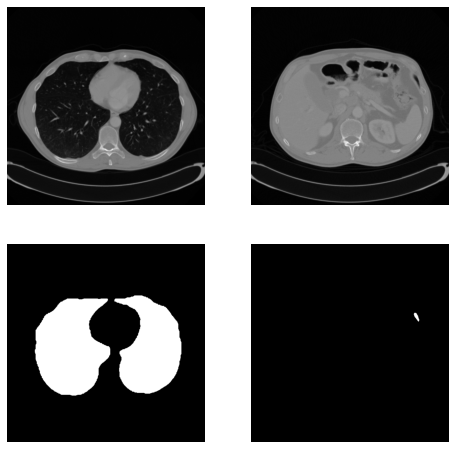

In [38]:
K = 2
ss = [14, 44]
print('axial indeces:')

img = image
segm = prediction > 0.5
# targ = target

lim1 = 0
lim2 = segm.shape[0]
lim3 = 0
lim4 = segm.shape[1]

# lim1 = 50
# lim2 = 200
# lim3 = 50
# lim4 = 200

fig, ax = plt.subplots(nrows=2, ncols=K, figsize=(4 * K, 4 * 2))
row = 0
for i, s in enumerate(ss):
    axial = img[..., s][lim1:lim2, lim3:lim4]
    ax[row, i].imshow(axial, cmap='gray')
    ax[row, i].axis('off')

row = 1
for i, s in enumerate(ss):
    axial = segm[..., s][lim1:lim2, lim3:lim4]
    ax[row, i].imshow(axial, cmap='gray')
    ax[row, i].axis('off')
    
# row = 2
# for i, s in enumerate(ss):
#     axial = targ[..., s][lim1:lim2, lim3:lim4]
#     ax[row, i].imshow(axial, cmap='gray')
#     ax[row, i].axis('off')

In [21]:
for s in range(segm.shape[2]):
    if segm[..., s].sum() > 0:
        print(s, segm[..., s].sum())

0 64177
1 64527
2 64666
3 64759
4 64763
5 64731
6 64744
7 64701
8 64579
9 64478
10 64501
11 64447
12 64244
13 64252
14 64189
15 63955
16 63662
17 63347
18 62967
19 62441
20 61553
21 57929
22 54294
23 51727
24 49354
25 47327
26 44850
27 42115
28 36647
29 29914
30 23642
31 18608
32 15258
33 12212
34 9798
35 7787
36 6066
37 4629
38 3308
39 2320
40 1499
41 955
42 615
43 409
44 159


In [39]:
dir(dataset)

['boxes',
 'fold',
 'id',
 'ids',
 'image',
 'resolution',
 'segmentation',
 'shape',
 'spacing',
 'subject']

In [41]:
dataset.boxes(uid)

{'liver': [136, 68, 22, 377, 312, 69],
 'kidney-r': [253, 130, 44, 348, 213, 79],
 'kidney-l': [269, 304, 36, 355, 394, 73],
 'femur-r': [237, 104, 123, 305, 172, 138],
 'femur-l': [244, 343, 125, 311, 410, 139],
 'bladder': [180, 194, 118, 319, 315, 139],
 'heart': [141, 212, 1, 272, 351, 30],
 'spleen': [247, 331, 29, 358, 442, 54],
 'pancreas': [193, 217, 41, 260, 346, 63]}